In [1]:
# %%
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- Utility: Find the Contrastive_Learning root dynamically ---
def find_contrastive_root(start: Path = Path.cwd()) -> Path:
    for parent in start.resolve().parents:
        if parent.name == "Contrastive_Learning":
            return parent
    raise RuntimeError("❌ Could not find 'Contrastive_Learning' directory from current path.")

# --- Detect and set CONTRASTIVE_ROOT environment variable ---
root_path = str(find_contrastive_root())
os.environ["CONTRASTIVE_ROOT"] = root_path
print(f"✅ CONTRASTIVE_ROOT set to: {root_path}")



# --- Root Paths ---
ROOT_RESULTS = f"{root_path}/files/results"
DATA_BASE = f"{root_path}/data/ASCOT"

# --- Ground Truth Binary Files ---
GT_HIGH = f"{DATA_BASE}/variable_cassette_exons_with_binary_labels_HIGH.csv"
GT_LOW  = f"{DATA_BASE}/variable_cassette_exons_with_binary_labels_LOW.csv"

# --- Output directory ---
OUT_DIR = f"{ROOT_RESULTS}/../classification_eval"
os.makedirs(OUT_DIR, exist_ok=True)


✅ CONTRASTIVE_ROOT set to: /gpfs/commons/home/atalukder/Contrastive_Learning


In [2]:
# %%
def get_prediction_file(result_file_name):
    """
    Given a result folder (exprmnt_YYYY_MM_DD__), find its test_set prediction file.
    """
    eval_dir = f"{ROOT_RESULTS}/{result_file_name}/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv"
    return eval_dir
    # if not os.path.exists(eval_dir):
    #     raise FileNotFoundError(f"❌ Folder not found: {eval_dir}")
    # for fn in os.listdir(eval_dir):
    #     if "predictions" in fn and fn.endswith(".tsv"):
    #         return os.path.join(eval_dir, fn)
    # raise FileNotFoundError(f"❌ No predictions TSV found in {eval_dir}")


In [26]:
def compute_classification_metrics_per_exon(gt_file, pred_file, model_name, expression_type, txt_writer=None):
    """
    Compute per-EXON classification metrics for HIGH/LOW exons.
    Each exon is treated as one sample (across all tissues).
    """
    gt = pd.read_csv(gt_file)
    pred = pd.read_csv(pred_file, sep="\t")

    gt.columns = gt.columns.str.strip()
    pred.columns = pred.columns.str.strip()
    pred.columns = [c.replace("--", " - ") for c in pred.columns]

    # Detect PSI scale
    sample_vals = pred.select_dtypes(include=["float", "int"]).iloc[:, 1:].values.flatten()
    median_val = pd.Series(sample_vals).median()
    scale_factor = 100 if median_val < 1 else 1
    if scale_factor == 100:
        print(f"🔁 Detected PSI in [0,1] → scaling ×100 for {model_name}")
    pred.iloc[:, 1:] = pred.iloc[:, 1:] * scale_factor

    # Identify shared tissue columns
    tissue_cols = [c for c in pred.columns if c in gt.columns and c != "exon_id"]

    gt_renamed = gt.rename(columns={c: f"{c}_gt" for c in tissue_cols})
    pred_renamed = pred.rename(columns={c: f"{c}_pred" for c in tissue_cols})
    merged = pd.merge(gt_renamed, pred_renamed, on="exon_id", how="inner")

    results = []
    for _, row in merged.iterrows():
        y_true = row[[f"{t}_gt" for t in tissue_cols]].astype(int).values
        y_prob = row[[f"{t}_pred" for t in tissue_cols]].values / 100.0

        # Skip exon if GT has no variation
        if len(set(y_true)) < 2:
            continue
        
        if expression_type == "HIGH":
            y_pred = (y_prob < 0.5).astype(int)
        else:
            y_pred = (y_prob > 0.5).astype(int)

        exon_metrics = {
            "model": model_name,
            "expression_type": expression_type,
            "exon_id": row["exon_id"],
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "auroc": roc_auc_score(y_true, y_prob),
            "auprc": average_precision_score(y_true, y_prob),
        }
        results.append(exon_metrics)

    df = pd.DataFrame(results)
    # --- Print averages ---
    if df.empty:
        summary_text = f"⚠️ No valid exons found for {model_name} ({expression_type})\n"
        print(summary_text.strip())
        return df, summary_text

    # --- Compute averages ---
    mean_metrics = df[["accuracy", "precision", "recall", "f1", "auroc", "auprc"]].mean().round(4)
    n_exons = len(df)
    summary_lines = [
        f"\n📊 {model_name} ({expression_type} exons)",
        f"   n_exons   : {n_exons}",
    ] + [f"   {k:<10}: {v:.4f}" for k, v in mean_metrics.items()]
    summary_text = "\n".join(summary_lines) + "\n"

    # print(summary_text)
    return df, summary_text

In [25]:
# %%
def evaluate_model_classification(result_file_name, model_user_name_norun):
    """
    Evaluate HIGH and LOW exon classification performance for a model
    using the user's defined naming convention.
    """
    pred_file = get_prediction_file(result_file_name)
    print(f"📂 Found predictions for {model_user_name_norun} → {pred_file}")

    # Evaluate high and low expression exons
    df_high,txt_high = compute_classification_metrics_per_exon(GT_HIGH, pred_file, model_user_name_norun, "HIGH")
    df_low, txt_low  = compute_classification_metrics_per_exon(GT_LOW, pred_file, model_user_name_norun, "LOW")

    combined = pd.concat([df_high, df_low], ignore_index=True)
    out_csv = f"{OUT_DIR}/{model_user_name_norun}_classification_metrics.csv"
    combined.to_csv(out_csv, index=False)
    print(f"✅ Saved classification metrics → {out_csv}")
    return combined, txt_high + txt_low


In [5]:
def plot_classification_summary(results_df, metric="auprc", out_name=None):
    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=results_df,
        x="expression_type",
        y=metric,
        hue="model",
        showfliers=False
    )
    plt.ylabel(metric.upper())
    plt.title(f"Per-exon {metric.upper()} distribution across models (HIGH/LOW exons)")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    if out_name:
        out_path = f"{OUT_DIR}/{out_name}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"📊 Saved figure → {out_path}")
    plt.show()


In [27]:
SUMMARY_TXT = f"{OUT_DIR}/classification_summary.txt"
summary_lines = ["===== MODEL CLASSIFICATION SUMMARY ====="]

# --- Model 1 ---
result_file_name1 =  "exprmnt_2025_10_28__20_28_29" # EMPRAIPsi_200bpIntrons_mtspliceHyperparams_2025_10_28__20_28_29
model1_user_name_norun = '200bpIntrons_mtspliceHyperparams'
df_model1, txt_model1 = evaluate_model_classification(result_file_name1, model1_user_name_norun)
summary_lines += [txt_model1]

# --- Model 2 ---
result_file_name2 =  "exprmnt_2025_10_28__20_12_58" # EMPRAIPsi_300bpIntrons_mtspliceHyperparams_2025_10_28__20_12_58
model2_user_name_norun = '300bpIntrons_mtspliceHyperparams'
df_model2, txt_model2 = evaluate_model_classification(result_file_name2, model2_user_name_norun)
summary_lines += [txt_model2]

# --- SOTA ---
sota_result_dir = "mtsplice_originalTFweight_results/intron_300bp_results"
sota_model_name_norun = "MTSplice_original_SOTA"
sota_pred_file = f"{ROOT_RESULTS}/{sota_result_dir}/test_all_tissues_predicted_psi.tsv"
print(f"📂 Using SOTA file → {sota_pred_file}")

df_sota_high, txt_sota_high = compute_classification_metrics_per_exon(GT_HIGH, sota_pred_file, sota_model_name_norun, "HIGH")
df_sota_low, txt_sota_low  = compute_classification_metrics_per_exon(GT_LOW,  sota_pred_file, sota_model_name_norun, "LOW")
summary_lines += [txt_sota_high, txt_sota_low]

df_sota = pd.concat([df_sota_high, df_sota_low], ignore_index=True)
df_sota.to_csv(f"{OUT_DIR}/{sota_model_name_norun}_classification_metrics.csv", index=False)

with open(SUMMARY_TXT, "w") as f:
    f.write("\n".join(summary_lines))



📂 Found predictions for 200bpIntrons_mtspliceHyperparams → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_28__20_28_29/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
✅ Saved classification metrics → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/200bpIntrons_mtspliceHyperparams_classification_metrics.csv
📂 Found predictions for 300bpIntrons_mtspliceHyperparams → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_28__20_12_58/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
✅ Saved classification metrics → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/300bpIntrons_mtspliceHyperparams_classification_metrics.csv
📂 Using SOTA file → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/mtsplice_originalTFweight_results/intron_300bp_results/t

✅ Combined summary saved → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/combined_classification_summary.csv
📊 Saved figure → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/AUPRC_SOTA_vs_models.png


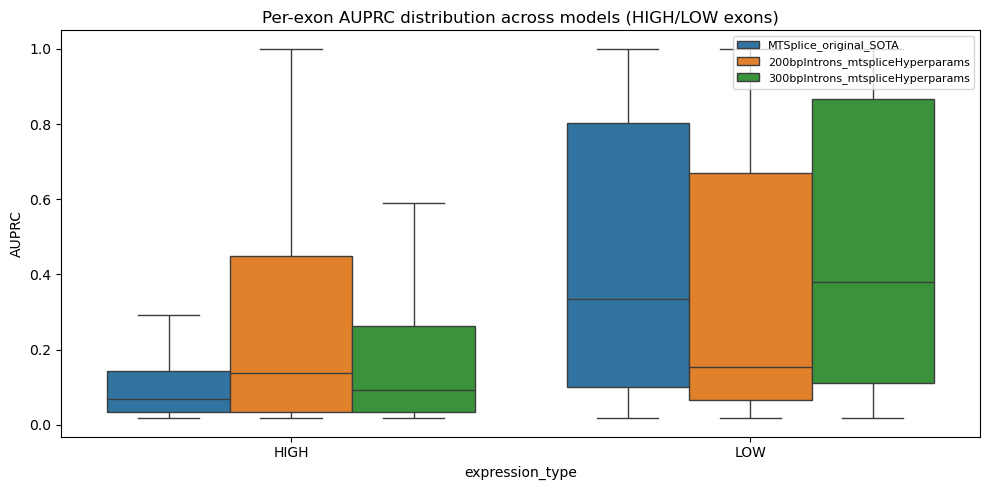

📊 Saved figure → /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/../classification_eval/AUROC_SOTA_vs_models.png


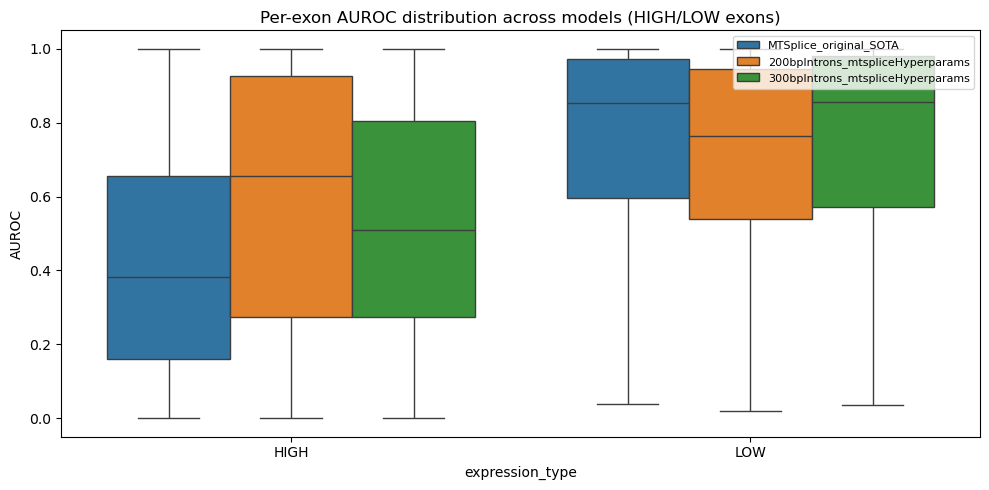

In [28]:
combined_all = pd.concat([df_sota, df_model1, df_model2], ignore_index=True)
combined_all.to_csv(f"{OUT_DIR}/combined_classification_summary.csv", index=False)
print(f"✅ Combined summary saved → {OUT_DIR}/combined_classification_summary.csv")

plot_classification_summary(combined_all, metric="auprc", out_name="AUPRC_SOTA_vs_models")
plot_classification_summary(combined_all, metric="auroc", out_name="AUROC_SOTA_vs_models")
